<a href="https://colab.research.google.com/github/MarioAvolio/AI-Project/blob/main/Question_Answering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt # plotting
import numpy as np

In [2]:
!pip uninstall transformers -y # https://github.com/huggingface/transformers/issues/22816
!pip install transformers==4.28.0
!pip install accelerate -U
from transformers import Trainer, TrainingArguments

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 4.5 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
PATH_PROJ = "/content/drive/MyDrive/AI-proj/"

In [5]:
import pandas as pd
import os
import matplotlib.pyplot as plt # plotting
import numpy as np

In [6]:
!pip uninstall transformers -y # https://github.com/huggingface/transformers/issues/22816
!pip install transformers==4.28.0
!pip install accelerate -U
from transformers import Trainer, TrainingArguments

Found existing installation: transformers 4.28.0
Uninstalling transformers-4.28.0:
  Successfully uninstalled transformers-4.28.0
  Using cached transformers-4.28.0-py3-none-any.whl (7.0 MB)


In [7]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [8]:
PATH_PROJ = "/content/drive/MyDrive/AI-proj/"

In [9]:
!pip install datasets # https://github.com/huggingface/datasets


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 8.7 MB/s eta 0:00:00


In [10]:
from datasets import get_dataset_config_names
domains = get_dataset_config_names("subjqa")
domains # ['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

Building a QA system for the Movies domain.

In [11]:
from datasets import load_dataset
subjqa = load_dataset("subjqa", "movies")

Generating train split:   0%|          | 0/1369 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/291 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/261 [00:00<?, ? examples/s]

Dataset subjqa downloaded and prepared to /root/.cache/huggingface/datasets/subjqa/movies/1.1.0/2c12e496c4c675ab4a57ffb5d3f538f2e7b89793956e50da37126393ce23b6c6. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [32]:
subjqa["train"]

Dataset({
    features: ['domain', 'nn_mod', 'nn_asp', 'query_mod', 'query_asp', 'q_reviews_id', 'question_subj_level', 'ques_subj_score', 'is_ques_subjective', 'review_id', 'id', 'title', 'context', 'question', 'answers'],
    num_rows: 1369
})

In [33]:
# Like other question answering datasets on the Hub, SubjQA stores the answers to
# each question as a nested dictionary. For example, if we inspect one of the rows in the
# answers column:
print(subjqa["train"]["answers"][10])


{'text': ['It is simply astounding', 'The movie is really shocking and appalling'], 'answer_start': [164, 1518], 'answer_subj_level': [1, 1], 'ans_subj_score': [1.0, 1.0], 'is_ans_subjective': [True, True]}


 To explore the dataset more easily, we’ll flatten these nested columns with the flatten() method and convert each split to a Pandas
DataFrame as follows

In [13]:
import pandas as pd
dfs = {split: dset.to_pandas() for split, dset in subjqa.flatten().items()}
for split, df in dfs.items():
  print(f"Number of questions in {split}: {df['id'].nunique()}")

Number of questions in train: 1369
Number of questions in test: 291
Number of questions in validation: 261


Let’s focus on these columns and take a look at a few of the training examples. We can
use the sample() method to select a random sample:

In [14]:
qa_cols = ["title", "question", "answers.text", "answers.answer_start", "context"]
sample_df = dfs["train"][qa_cols].sample(2, random_state=7)
sample_d

,title,question,answers.text,answers.answer_start,context
263,630428845X,How is the story?,[],[],This has got to be one of the most boring and ...
313,630575067X,How is character?,[the digital characters],[1071],"Like most Star Wars fans, I literally counted ..."


From these examples we can make a few observations. First, the questions are not
grammatically correct, which is quite common in the FAQ sections of ecommerce
websites. Second, an empty answers.text entry denotes “unanswerable” questions
whose answer cannot be found in the review. Finally, we can use the start index and
length of the answer span to slice out the span of text in the review that corresponds
to the answer:

In [15]:
start_idx = sample_df["answers.answer_start"].iloc[1][0]
end_idx = start_idx + len(sample_df["answers.text"].iloc[1][0])
sample_df["context"].iloc[1][start_idx:end_idx]

'the digital characters'

Next, let’s get a feel for what types of questions are in the training set by counting the
questions that begin with a few common starting words:

In [16]:
counts = {}
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why", "When","What","Who","Whom","Whose","Which"]


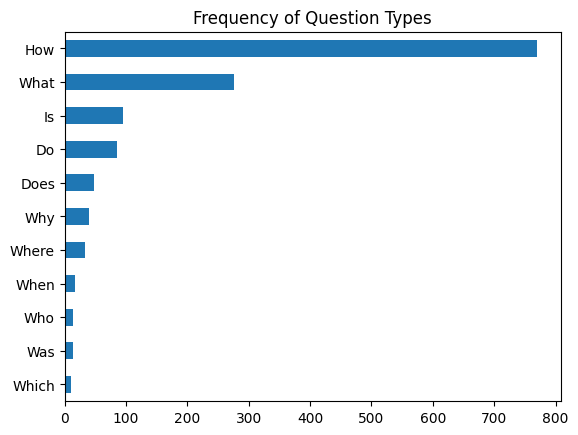

In [17]:

for q in question_types:
  try:
    counts[q] = dfs["train"]["question"].str.startswith(q).value_counts()[True]
  except:
    continue
pd.Series(counts).sort_values().plot.barh()
plt.title("Frequency of Question Types")
plt.show()

We can see that questions beginning with “How”, “What”, and “Is” are the most common ones, so let’s have a look at some examples:

In [18]:
for question_type in ["How", "What", "Is"]:
  for question in (
    dfs["train"][dfs["train"].question.str.startswith(question_type)]
    .sample(n=3, random_state=42)['question']):
    print(question)

How is the story line?
How is the music?
How can I read the set story at this hotel?
What is the price of the dvd?
What is the really things?
What is the quality of the paint?
Is the main character a good actor?
Is the color better?
Is the actor a funny acting?


## Extracting Answers from Text


The first thing we’ll need for our QA system is to find a way to identify a potential
answer as a span of text in a customer review. The most common way to extract answers from text is by framing the problem as a
span classification task, where the start and end tokens of an answer span act as the
labels that a model needs to predict.

Since our training set is relatively small, a good strategy is
to start with a language model that has already been fine-tuned on a large-scale QA
dataset like SQuAD. In general, these models have strong reading comprehension
capabilities and serve as a good baseline upon which to build a more accurate system.

What model we can choose? [Click here](https://huggingface.co/models?pipeline_tag=question-answering&sort=trending&search=squad)

In [19]:
# Trans formers provides a convenient AutoTokenizer class that allows you to quickly load
# the tokenizer associated with a pretrained model
# The AutoTokenizer class belongs to a larger set of “auto” classes whose job is to auto‐
# matically retrieve the model’s configuration, pretrained weights, or vocabulary from
# the name of the checkpoint.
from transformers import AutoTokenizer

model_ckpt = "deepset/roberta-base-squad2" # https://huggingface.co/deepset/roberta-base-squad2
tokenizer = AutoTokenizer.from_pretrained(model_ckpt) # we just call its from_pretrained() method, providing the ID of a model on the Hub or a local file path.



To see the model in action, let’s first try to extract an answer from a short passage of
text. In extractive QA tasks, the inputs are provided as (question, context) pairs, so we
pass them both to the tokenizer as follows:

In [20]:
question= "Why is model conversion important?"
context= "The option to convert models between FARM and transformers gives freedom to the user and let people easily switch between frameworks."

inputs = tokenizer(question, context)
inputs

{'input_ids': [0, 7608, 16, 1421, 10012, 505, 116, 2, 2, 133, 1973, 7, 10304, 3092, 227, 274, 31874, 8, 7891, 268, 2029, 3519, 7, 5, 3018, 8, 905, 82, 2773, 5405, 227, 32480, 4, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [21]:
tokens = tokenizer.convert_ids_to_tokens(inputs.input_ids)
print(tokens)

['<s>', 'Why', 'Ġis', 'Ġmodel', 'Ġconversion', 'Ġimportant', '?', '</s>', '</s>', 'The', 'Ġoption', 'Ġto', 'Ġconvert', 'Ġmodels', 'Ġbetween', 'ĠF', 'ARM', 'Ġand', 'Ġtransform', 'ers', 'Ġgives', 'Ġfreedom', 'Ġto', 'Ġthe', 'Ġuser', 'Ġand', 'Ġlet', 'Ġpeople', 'Ġeasily', 'Ġswitch', 'Ġbetween', 'Ġframeworks', '.', '</s>']


In [22]:
print(tokenizer.convert_tokens_to_string(tokens))

<s>Why is model conversion important?</s></s>The option to convert models between FARM and transformers gives freedom to the user and let people easily switch between frameworks.</s>


In [23]:
tokenizer.model_input_names, tokenizer.vocab_size, tokenizer.model_max_length

(['input_ids', 'attention_mask'], 50265, 512)

In [24]:
inputs = tokenizer(question, context, return_tensors="pt")

Here we’ve returned PyTorch Tensor objects, since we’ll need them to run the forward pass through the model. If we view the tokenized inputs as a table:

In [25]:
inputs

{'input_ids': tensor([[    0,  7608,    16,  1421, 10012,   505,   116,     2,     2,   133,
          1973,     7, 10304,  3092,   227,   274, 31874,     8,  7891,   268,
          2029,  3519,     7,     5,  3018,     8,   905,    82,  2773,  5405,
           227, 32480,     4,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [26]:
print(tokenizer.decode(inputs["input_ids"][0]))
print(f"Input tensor shape: {inputs['input_ids'].size()}") # As we can see, the resulting tensor has the shape [batch_size, n_tokens]


<s>Why is model conversion important?</s></s>The option to convert models between FARM and transformers gives freedom to the user and let people easily switch between frameworks.</s>
Input tensor shape: torch.Size([1, 34])


Now that our text is tokenized, we just need to instantiate the model with a QA head
and run the inputs through the forward pass:

In [27]:
import torch
from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)

with torch.no_grad():
  '''
  Here we’ve used the torch.no_grad() context manager to disable the automatic calculation of the gradient.
  This is useful for inference since it reduces the memory footprint of the computations.
  '''
  outputs = model(**inputs)
print(outputs)

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[ 2.1691, -6.0923, -8.1997, -7.6676, -8.6942, -7.5250, -9.1025, -8.4655,
         -5.9657,  2.0334,  0.5248, -1.1092, -0.6666, -1.2680, -2.7834, -4.1984,
         -6.5456, -6.9495, -3.6798, -5.9952,  4.6541,  4.0024, -3.1714, -1.7563,
         -1.5274, -2.7023,  2.4152, -2.4580, -1.1586, -1.2393, -4.4350, -3.3643,
         -2.0520, -7.1857]]), end_logits=tensor([[ 2.7784, -6.9623, -8.1543, -8.6904, -7.3144, -6.7994, -6.7297, -5.1045,
         -0.8470, -5.2608, -3.8302, -6.5672, -6.2452, -4.8464, -6.8564, -6.7473,
         -2.1737, -7.3393, -4.9755, -0.6742, -2.4742,  2.7718, -2.6973, -3.3356,
          4.6363, -1.5485, -4.1409, -3.7737, -2.6754, -2.3832, -2.8759,  4.5230,
          3.6473, -2.1456]]), hidden_states=None, attentions=None)


The QA head corresponds to a linear layer
that takes the hidden states from the encoder and computes the logits for the start
and end spans.  To convert the
outputs into an answer span, we first need to get the logits for the start and end
tokens:

In [28]:
start_logits = outputs.start_logits
end_logits = outputs.end_logits

In [29]:
print(f"Input IDs shape: {inputs.input_ids.size()}")
print(f"Start logits shape: {start_logits.size()}")
print(f"End logits shape: {end_logits.size()}")

Input IDs shape: torch.Size([1, 34])
Start logits shape: torch.Size([1, 34])
End logits shape: torch.Size([1, 34])


We see that there are two logits (a start and end) associated with each input token. To get the final answer, we can compute the argmax over the start and end token logits and then slice the span from the inputs

In [30]:
import torch
start_idx = torch.argmax(start_logits)
end_idx = torch.argmax(end_logits) + 1
answer_span = inputs["input_ids"][0][start_idx:end_idx]
answer = tokenizer.decode(answer_span)
print(f"Question: {question}")
print(f"Answer: {answer}")

Question: Why is model conversion important?
Answer:  gives freedom to the user


all of these preprocessing and postprocessing
steps are conveniently wrapped in a dedicated pipeline. We can instantiate the pipe‐
line by passing our tokenizer and fine-tuned model as follows:

In [31]:
from transformers import pipeline
pipe = pipeline("question-answering", model=model, tokenizer=tokenizer)
pipe(question=question, context=context, top_k=3)

[{'score': 0.21171392500400543,
  'start': 59,
  'end': 84,
  'answer': 'gives freedom to the user'},
 {'score': 0.18904224038124084,
  'start': 59,
  'end': 132,
  'answer': 'gives freedom to the user and let people easily switch between frameworks'},
 {'score': 0.11033766716718674,
  'start': 65,
  'end': 84,
  'answer': 'freedom to the user'}]

### Dealing with long passages
One subtlety faced by reading comprehension models is that the context often contains more tokens than the maximum sequence length of the model (which is usually
a few hundred tokens at most). The standard way to deal with
this is to apply a sliding window across the inputs, where each window contains a passage of tokens that fit in the model’s context.

In [39]:
example = dfs["train"].iloc[0][["question", "context"]]

# we can set return_overflowing_tokens=True in the tokenizer to
# enable the sliding window. The size of the sliding window is controlled by the
# max_seq_length argument, and the size of the stride is controlled by doc_stride
tokenized_example = tokenizer(example["question"], example["context"],
                    return_overflowing_tokens=True, max_length=100,truncation=True,
                    stride=25)

In this case we now get a list of input_ids, one for each window. Let’s check the num‐
ber of tokens we have in each window:

In [40]:
for idx, window in enumerate(tokenized_example["input_ids"]):
  print(f"Window #{idx} has {len(window)} tokens")

Window #0 has 100 tokens
Window #1 has 100 tokens
Window #2 has 100 tokens
Window #3 has 100 tokens
Window #4 has 100 tokens
Window #5 has 100 tokens
Window #6 has 100 tokens
Window #7 has 100 tokens
Window #8 has 100 tokens
Window #9 has 100 tokens
Window #10 has 100 tokens
Window #11 has 97 tokens


In [41]:
for window in tokenized_example["input_ids"]:
  print(f"{tokenizer.decode(window)} \n")

<s>How did you like the movie?</s></s>Well, I have to admit I wasn't expecting to like this movie, having read all the bad press surrounding it.  But I saw it last night on a whim and I have to say I thought it was fantastic!  Firstly, as a movie it is incredibly well shot.  The scenery is wonderful and the sets are painstakingly recreated - never once do you doubt this is 1st century Palestine.The acting starts off a little</s> 

<s>How did you like the movie?</s></s> sets are painstakingly recreated - never once do you doubt this is 1st century Palestine.The acting starts off a little strained in the garden scene, when the movie is just finding it's feet (and the audience is coming to terms with the fact that the movie isn't some horrible, cheap propaganda short, but a proper movie) but quickly becomes impressive and ends up brutally real.Gibson has set out to make a compelling dram</s> 

<s>How did you like the movie?</s></s> a proper movie) but quickly becomes impressive and ends u

## Using Haystack to Build a QA Pipeline
In our simple answer extraction example, we provided both the question and the context to the model. However, in reality our system’s users will only provide a question
about a product, so we need some way of selecting relevant passages from among all
the reviews in our corpus.


### Initializing a document store
Elasticsearch is a search engine that is capable of handling a diverse range of data types,
including textual, numerical, geospatial, structured, and unstructured. Its ability to
store huge volumes of data and quickly filter it with full-text search features makes it
especially well suited for developing QA systems.

In [42]:
url = """https://artifacts.elastic.co/downloads/elasticsearch/\
elasticsearch-7.9.2-linux-x86_64.tar.gz"""
!wget -nc -q {url}
!tar -xzf elasticsearch-7.9.2-linux-x86_64.tar.gz

Next we need to start the Elasticsearch server. Since we’re running all the code in this
book within Jupyter notebooks, we’ll need to use Python’s Popen() function to spawn a new process. While we’re at it, let’s also run the subprocess in the background using
the chown shell command

In [43]:
import os
from subprocess import Popen, PIPE, STDOUT

# Run Elasticsearch as a background process
!chown -R daemon:daemon elasticsearch-7.9.2


# In the Popen() function, the args specify the program we wish to execute, while
# stdout=PIPE creates a new pipe for the standard output and stderr=STDOUT collects
# the errors in the same pipe. The preexec_fn argument specifies the ID of the subpro‐
# cess we wish to use.
es_server = Popen(args=['elasticsearch-7.9.2/bin/elasticsearch'], stdout=PIPE, stderr=STDOUT, preexec_fn=lambda: os.setuid(1))

# Wait until Elasticsearch has started
!sleep 30

By default, Elasticsearch runs locally on port 9200, so we can test
the connection by sending an HTTP request to localhost:

In [44]:
!curl -X GET "localhost:9200/?pretty"

{
  "name" : "b5ba5a8364ec",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "KLA5ZiMoTxON8WP9aPulrQ",
  "version" : {
    "number" : "7.9.2",
    "build_flavor" : "default",
    "build_type" : "tar",
    "build_hash" : "d34da0ea4a966c4e49417f2da2f244e3e97b4e6e",
    "build_date" : "2020-09-23T00:45:33.626720Z",
    "build_snapshot" : false,
    "lucene_version" : "8.6.2",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


Now that our Elasticsearch server is up and running, the next thing to do is instantiate the document store

In [ ]:
# https://docs.haystack.deepset.ai/docs/installation

!pip install --upgrade pip
!pip install 'farm-haystack[all]' ## or 'all-gpu' for the GPU-enabled dependencies

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.3 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 792.9/792.9 kB 7.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 MB 8.4 MB/s eta 0:00:00
  Obtaining dependency information for boto3 from https://files.pythonhosted.org/packages/0a/5c/055aa43caaad7e75a481ec8f3d74435d6e248d8171ee14ea826f34eecbd4/boto3-1.28.5-py3-none-any.whl.metadata
  Obtaining dependency information for onnxruntime from https://files.pythonhosted.org/packages/2f/e2/ced4e64433097cb14425098ce3c6200b83d226005e8c23ba5bac44c89ab9/on

In [ ]:

from haystack.document_store.elasticsearch import ElasticsearchDocumentStore
# Return the document embedding for later use with dense retriever
document_store = ElasticsearchDocumentStore(return_embedding=True)
